<a href="https://colab.research.google.com/github/kumariabha/OS_LAB/blob/master/working_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Place all imports here
import numpy as np
import pandas as pd
import random
from copy import copy, deepcopy


In [2]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: ignored

In [ ]:
import sys
sys.path.insert(0,"/content/drive/My Drive/sdn-controllers-load-balancing-main")
%cd /content/drive/My Drive/sdn-controllers-load-balancing-main

/content/drive/My Drive/sdn-controllers-load-balancing-main


In [ ]:
# import os
# os.chdir("/content/drive/")
# with open("/content/drive/My Drive/sdn-controllers-load-balancing-main/output.txt",'w') as out:


# **Generate the data**

Here is the idea we are using for the same:

1. We have flow arrivals as Poisson processes with parameters λ. Thus the inter-arrival times are distributed as exponential random variables with paramteres λ.

2. The service time is exponentially distributed with parameter μ. We assume no queues and infinite number of servers.

3. To implement this, keep one single set of tuples ordered by the first element. A typical tuple looks like this:
(timestamp, switch, flow +/-)

4. The final table will look something like this:

>> timestamp &nbsp;&nbsp; 1 2 3 4 ... 34

---
>> 0.0025 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1 0 0 0 .... 0 <br>
>> .<br>
>> .<br>
>> .<br>
>> 0.1210 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2 1 0 3 .... 4

In [ ]:
switch_count = 11
maxiter=8000
Cmax=5

# Randomly generating lambda and mu values (same for all) for 34 switches
arrival_lambda_list = list(np.random.randint(low=110, high=115, size=switch_count))
service_mu_list = [np.random.randint(low=115, high=120)]*switch_count

print("Arrival Lambda = {}".format(arrival_lambda_list))
print("Service Mu = {}".format(service_mu_list))
# Generate the data
data = []
event_count = 200

for i in range(0, switch_count):
    arrival_times = np.random.exponential(1/arrival_lambda_list[i], event_count)
   # print(arrival_times)

    arrival_timestamps = np.cumsum(arrival_times)
   # print(arrival_timestamps)
    service_times = np.random.exponential(1/service_mu_list[i], event_count)
   # print(service_times)
    departure_timestamps = arrival_timestamps + service_times

    for j in range(0, event_count):
        data.append((arrival_timestamps[j], i, 1))
        data.append((departure_timestamps[j], i, -1))

# Sorts the data as per the first element (timestamps in our case)
data.sort()
table_data = []

temp_list = [0] * switch_count

for i in range(0,len(data)):
    timestamp = data[i][0]
    switch_number = data[i][1]
    update = data[i][2]

    temp_list[switch_number]+=update
    table_data.append([item for item in temp_list])

final_data = pd.DataFrame(table_data)
print((final_data))
final_csv_data = final_data.to_csv('data_abilene.csv')
# final_data=pd.read_csv('toy_data.csv')
# final_data = pd.DataFrame(final_data)
# print((final_data))

Arrival Lambda = [114, 110, 110, 113, 110, 113, 112, 113, 110, 114, 114]
Service Mu = [118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118]
      0   1   2   3   4   5   6   7   8   9   10
0      0   0   0   0   0   0   0   1   0   0   0
1      0   0   0   0   0   1   0   1   0   0   0
2      0   0   0   0   0   1   0   1   0   1   0
3      0   0   0   0   1   1   0   1   0   1   0
4      0   0   0   0   1   1   0   1   1   1   0
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
4395   0   0   2   0   0   0   0   0   0   0   0
4396   0   0   1   0   0   0   0   0   0   0   0
4397   0   0   2   0   0   0   0   0   0   0   0
4398   0   0   1   0   0   0   0   0   0   0   0
4399   0   0   0   0   0   0   0   0   0   0   0

[4400 rows x 11 columns]


Now we work on creating controllers and assigning switches to them. In our new model, controllers are not switches themselves.

In [ ]:
final_data=pd.read_csv('toy_data.csv')
final_data = pd.DataFrame(final_data)
print((final_data))

   Unnamed: 0   0   1   2   3   4   5   6   7   8   9  10
0           0   0   4   5   6   0  16   0   0   1  21   2
1           1  10  19  10  19   3  20   6   4  10  35  15
2           2  13  30   1  26  17  25  20  10  18  36  19
3           3  28  30   4  46  23  31  20  10  20  47  26
4           4  41  31   4  57  30  47  33  20  20  50  30
5           5  50  40   0  72  46  68  33  20  23  59  30
6           6  55  44   0  91  54  98  35  29  53  66  47
7           7  50  44   1  82  65  98  45  30  50  60  70
8           8  70  64  30  91  70  84  70  39  44  75  80


In [ ]:
####### Graph Building using data from Arnes.gml ########

import networkx as nx
import time
import random
import math
import numpy as np
import pandas as pd
import ast

from math import radians, cos, sin, asin, sqrt
from collections import defaultdict

####### Data collection, cleaning, and handling corner cases #######

#k = int(input("Enter the number of controllers to allocate: "))
k=3
start = time.time()
graph = nx.read_gml('/content/drive/My Drive/sdn-controllers-load-balancing-main/gml/Abilene.gml', label='id')

lat = nx.get_node_attributes(graph, "Latitude")
lon = nx.get_node_attributes(graph, "Longitude")

# Remove bad nodes from 'graph'
for node in list(graph.nodes):
    # removing nodes
    # (a) with undefined latitude or longitude
    # (b) that are isolated
    check_bad_node = lat.get(node) == None or lon.get(node) == None or nx.is_isolate(graph,node)
    if check_bad_node == True:
        graph.remove_node(node)


def dist_between_nodes(node_1, node_2):
    '''Compute distance between any 2 nodes of 'graph' using Haversine formula

    Args:
        node_1 (int): The first among the 2 graph nodes
        node_2 (int): The second among the 2 graph nodes

    Returns:
        dist: distanct between the two nodes
    '''
    lat_1 = radians(lat.get(node_1))
    lat_2 = radians(lat.get(node_2))
    lon_1 = radians(lon.get(node_1))
    lon_2 = radians(lon.get(node_2))

    # Applying Haversine formula
    dlon = lon_2 - lon_1
    dlat = lat_2 - lat_1
    a = sin(dlat/2)**2 + cos(lat_1)*cos(lat_2)*sin(dlon/2)**2
    c = 2*asin(sqrt(a))

    # Mean radius of Earth
    R = 6371.009
    dist = c*R

    return dist

# Assigning weights (based on distance) to the edges of the graph
for node in list(graph.nodes):
    for neighbor in list(graph.neighbors(node)):
        graph[node][neighbor]['weight'] = dist_between_nodes(node, neighbor)

# Removing edges with no weights assigned
for edge in list(graph.edges):
    if 'weight' not in graph.edges[edge] == False:
        graph.remove_edge(edge[0],edge[1])

#print(nx.info(graph))
n = nx.number_of_nodes(graph)

####### Graph building and Controllers' Cluster formation #######

# Store the graph as an adjacency list
adj_list = [];
for i in range(0,n):
    adj_list.append([])

for edge in graph.edges:
    i,j = edge
    adj_list[i].append(j)
    adj_list[j].append(i)

# Random sampling for controller index selection
controllers = random.sample(range(0,n),k)

# List of lists represents index of switches in particular controller
# e.g. [[s1,s2],[s3,s4],[s5]] controller distribution set
lol = []
for i in range(0,k):
    lol.append([])

# Controllers set
# Keeping copies for Greedy approach and Q-learning
controllers_Q = deepcopy(list(controllers))
controllers_G = deepcopy(list(controllers))
controllers_R = deepcopy(list(controllers))
print("\nControllers: \n{}\n".format(controllers))

def BFS(queue, adj_list, listx):
    '''Performs a breadth first search in the graph
    '''
    while queue:
        p = queue.pop(0)
        u, w = p
        for v in adj_list[u]:
            if listx[v] == math.inf:
                listx[v] = w + 1
                queue.append((v, w + 1))
    return listx

index = 0
for j in range(0, k):
    listx = n*[math.inf]
    listx[controllers[index]] = 0
    queue = []
    queue.append((controllers[index], 0))
    listx = BFS(queue, adj_list, listx)
    lol[j] = listx
    index += 1

transpose_list = np.transpose(lol).tolist()
minumum_pos = []

for x in transpose_list:
    min_ele = n+5
    for i in range(0, len(x)):
        if x[i] < min_ele:
            min_ele = x[i]
    ts = []
    for i in range(0, len(x)):
        if(x[i] == min_ele):
            ts.append(i)
    minumum_pos.append(random.choice(ts))

final = []
controller_sets = []
for i in range(0, k):
    controller_sets.append([])

for i in range(0, n):
    final.append((i, controllers[minumum_pos[i]]))
    controller_sets[minumum_pos[i]].append(i)

print('Cluster set for each controller: \n{}\n'.format(controller_sets))
controller_maps = {}
index = 0

for controller_set in controller_sets:
    switch_array, controller = [], controllers[index]
    for switch in controller_set:
        if switch != controller:
            switch_array.append(switch)
    controller_maps[controller] = switch_array
    index += 1

print('Cluster map for each controller: \n{}\n'.format(controller_maps))

def floyd_warshall(graph):
    d = defaultdict(set)
    cnt = defaultdict(set)
    inf = float('inf')

    # Initialising distance between all nodes as infinity
    for node1 in graph.nodes:
        for node2 in graph.nodes:
            d[(node1, node2)] = inf
            cnt[(node1, node2)] = inf

    # Changing the distance between adjacent nodes
    for edge in graph.edges:
        # Undirected graph
        d[(edge[0], edge[1])] = graph.edges[edge]['weight']
        d[(edge[1], edge[0])] = graph.edges[edge]['weight']
        cnt[(edge[0], edge[1])] = 1
        cnt[(edge[1], edge[0])] = 1

    for node in graph.nodes:
        d[(node, node)] = 0
        cnt[(node, node)] = 0

    # Updating the matrix
    for node1 in graph.nodes:
        for node2 in graph.nodes:
            for node3 in graph.nodes:
                if d[(node2, node3)] > d[(node2, node1)] + d[(node1, node3)]:
                    d[(node2, node3)] = d[(node2, node1)] + d[(node1, node3)]
                    d[(node3, node2)] = d[(node2, node3)]
                    cnt[(node2, node3)] = cnt[(node2, node1)] + cnt[(node1, node3)]
                    cnt[(node3, node2)] = cnt[(node2, node3)]

    return [d, cnt]


[dist, hop_count] = floyd_warshall(graph)

print('Having used Floyd Warshall algorithm, we obtain the following - (i) Dist and (ii) Hop Count')
print(dist)
print(hop_count)

# Keeping another copy of the controller set for Greedy approach
controller_sets_G = deepcopy(list(controller_sets))
print(controller_sets_G)

# Keeping another copy of the controller set for Random
controller_sets_R = deepcopy(list(controller_sets))
print(controller_sets_R)
# Keeping another copy of the controller set for Q-learning
controller_sets_Q = deepcopy(list(controller_sets))
print(controller_sets_Q)

load_array = [] # Array of maps, with each node mapped to a load
for i in final_data.index:
    #print(i)
    Load = dict(final_data.iloc[i])
    #Load ={eval(k):v for k,v in Load.items()}
    load_array.append(Load)

print(load_array)
len(load_array)



Controllers: 
[4, 6, 0]

Cluster set for each controller: 
[[4, 5], [3, 6, 7, 8, 10], [0, 1, 2, 9]]

Cluster map for each controller: 
{4: [5], 6: [3, 7, 8, 10], 0: [1, 2, 9]}

Having used Floyd Warshall algorithm, we obtain the following - (i) Dist and (ii) Hop Count
defaultdict(<class 'set'>, {(0, 0): 0, (0, 1): 1145.8388074802808, (0, 2): 328.49118676231217, (0, 3): 4672.736370637796, (0, 4): 4535.213728260484, (0, 5): 4534.741630597162, (0, 6): 3031.6180327636166, (0, 7): 2139.811904860677, (0, 8): 2327.9789601291973, (0, 9): 1200.4188858488951, (0, 10): 1409.1639850072984, (1, 0): 1145.8388074802808, (1, 1): 0, (1, 2): 1474.3299942425929, (1, 3): 3526.8975631575163, (1, 4): 3389.3749207802025, (1, 5): 3892.532100382933, (1, 6): 1885.779225283336, (1, 7): 993.9730973803962, (1, 8): 2035.9216468005036, (1, 9): 950.9295002796237, (1, 10): 263.3251775270176, (2, 0): 328.49118676231217, (2, 1): 1474.3299942425929, (2, 2): 0, (2, 3): 4823.104407469687, (2, 4): 4685.581765092374, (2, 5)

4400

In [ ]:
controller_dict={}
indx=0
for i in controllers:
  controller_dict[i]=indx
  indx+=1
print(controller_dict)

{4: 0, 6: 1, 0: 2}


# **Switch Migration Design**

In [ ]:
# Switch Migration Design
'''
LCi: the load of the controller Ci
CCi: the load capacity of the controller Ci
RCi: the load ratio of the controller Ci
LSk: the packet-in message sending rate of the switch Sk
R: mean load ratio of all controllers
D: load ratio deviation coefficient between two controllers
E: migrate switch efficiency between controllers
HSk: number of hops between the switch and the controller
'''

# A. Load Balancing

'''
Controllers' Load
Populating `controller_cluster_load` array
Eg - {c1:36363663, c2:3234325, c3:32523525, c4:3523535, c5:3542646}
Load for a controller is the sum of load on it + all it's switches
'''

def calculate_controller_cluster_load(time_step, controller_sets):
    controller_cluster_load = {}
    index = 0
    for controller_set in controller_sets:
        total_load = 0
        for switch in controller_set:
            total_load += load_array[time_step][switch]
            print(switch)
        controller_cluster_load[controllers[index]] = total_load
        index += 1
    return controller_cluster_load

# TEST ABOVE FUNCTION --------------------------------------
controller_cluster_load = calculate_controller_cluster_load(0, controller_sets)
print(controller_cluster_load)
# -----------------------------------------------------------

'''
Controllers' Load Capacity
For finding this, we assume the extreme most case, i.e, number of controllers = 1
For this, the load capacity at a given time step = sum of all load on all switches at that time step.
The `load capacity of all controllers` = max of the load capacity over all time steps, and assumed to be uniform for all controllers.
'''

def calculate_controller_load_capacity():
    load_capacity_at_ts = []
    for time_step in range(0,len(load_array)):
        values = load_array[time_step].values()
        total = sum(values)
        load_capacity_at_ts.append(total)
    return max(load_capacity_at_ts)

#CONTROLLERS_LOAD_CAPACITY = 1

'''
Controllers' Load Ratio
The `load ratio for a controller` is the ratio of it's load to load capacity
'''

def calculate_controller_cluster_load_ratio(controller_cluster_load):
    controller_cluster_load_ratio = {}
    CONTROLLERS_LOAD_CAPACITY = calculate_controller_load_capacity()
    for controller in controller_cluster_load:
        controller_cluster_load_ratio[controller] = controller_cluster_load[controller]/CONTROLLERS_LOAD_CAPACITY
    return controller_cluster_load_ratio

# TEST ABOVE FUNCTION ---------------------------------------
controller_cluster_load_ratio = calculate_controller_cluster_load_ratio(controller_cluster_load)
print(controller_cluster_load_ratio)
# -----------------------------------------------------------

'''
Controllers' Mean Load Ratio
The mean load ratio of controllers is given as mean of load ratios of all controllers
'''

def calculate_controller_mean_load_ratio(controller_cluster_load_ratio):
    values = controller_cluster_load_ratio.values()
    no_of_controllers = len(values)
    controller_mean_load_ratio = sum(values)/no_of_controllers
    return controller_mean_load_ratio

# TEST ABOVE FUNCTION ---------------------------------------
controller_mean_load_ratio = calculate_controller_mean_load_ratio(controller_cluster_load_ratio)
print(controller_mean_load_ratio)
# -----------------------------------------------------------

'''
Discrete Coefficient
The discrete coefficient is used to describe the degree of discrete of
the controller’s load ratio and the mean load ratio between controllers
'''

def calculate_discrete_coefficient(controller_cluster_load_ratio):
    controller_mean_load_ratio = calculate_controller_mean_load_ratio(controller_cluster_load_ratio)
    D_num = 0
    D_denom = controller_mean_load_ratio
    print(D_denom)
    no_of_controllers = len(controller_cluster_load_ratio.values())

    for controller in controller_cluster_load_ratio:
        load_ratio = controller_cluster_load_ratio[controller]
        D_num += ((load_ratio - controller_mean_load_ratio)**2)

    D_num = sqrt(D_num/no_of_controllers)
    print(D_num)
    if(D_denom == 0):
        return 0
    D_num = D_num/D_denom
    return D_num

# TEST ABOVE FUNCTION ---------------------------------------
discrete_coefficient = calculate_discrete_coefficient(controller_cluster_load_ratio)
print(discrete_coefficient)
# -----------------------------------------------------------


4
5
3
6
7
8
10
0
1
2
9
{4: 0, 6: 1, 0: 0}
{4: 0.0, 6: 0.047619047619047616, 0: 0.0}
0.015873015873015872
0.015873015873015872
0.022447834323382456
1.4142135623730947


In [ ]:
# B. Switch Migration Efficiency

'''
If the switch is migrating between controllers, there will be migration overhead.
Because the hop count HSk between the switch and the controller is different,
the load LSk of the switch to the controller is different, the migration efficiency
is expressed as the ratio of these 2 quantities: E(Ci, Sk) = LSk / HSk
'''

def calculate_switch_migration_efficiency(time_step, controller_sets):
    switch_migration_efficiency = {}
    index = 0

    for controller_set in controller_sets:
        controller = controllers[index]
        ECi = {}
        for switch in controller_set:
            if switch != controller:
                LSk = load_array[time_step][switch]
                HSk = hop_count[(controller, switch)]
                ECi[switch] = LSk
             #   ECi[switch] = LSk/HSk
        switch_migration_efficiency[controller] = ECi
        index += 1

    return switch_migration_efficiency

# TEST ABOVE FUNCTION ---------------------------------------
switch_migration_efficiency = calculate_switch_migration_efficiency(0, controller_sets)
print(switch_migration_efficiency)

# mean_switch_migration_efficiency = {}
# for controller in switch_migration_efficiency:
#     values = switch_migration_efficiency[controller].values()
#     l = len(values)
#     if l==0:
#         mean_switch_migration_efficiency[controller] = 0
#     else:
#         mean_switch_migration_efficiency[controller] = sum(values)/l
# print(mean_switch_migration_efficiency)
# -----------------------------------------------------------


{4: {5: 0}, 6: {3: 0, 7: 1, 8: 0, 10: 0}, 0: {1: 0, 2: 0, 9: 0}}


In [ ]:
# C. Migration Tuples Selection

# a. Migration Domain Selection:

'''
In a real-time changing network environment, the load of each controller also changes
fast. The traditional method tends to strip the selection process of the out-migration domain
and the in-migration domain, which introduces the probability of controller overload to some
extents, while it is also easy to bring migration conflicts and migration jitter in the
control plane. Next, a new selection algorithm will be proposed and which will add anti-collision
mechanism in the judgment part to avoid the two consequences of the commonly bad migration.
The switch migration domain selection algorithm is as follows:
'''

def select_migration_domain(controller_cluster_load_ratio, controller_mean_load_ratio, discrete_coefficient):
    out_migration_domain, in_migration_domain, migration_queue = set(), set(), set()
    D = discrete_coefficient
    R_mean = controller_mean_load_ratio

    for Ci, RCi in controller_cluster_load_ratio.items():
        for Cj, RCj in controller_cluster_load_ratio.items():
            if Ci!=Cj:
                D_CiCj = calculate_discrete_coefficient({Ci: RCi, Cj: RCj})

                if D_CiCj > D and RCi > R_mean and RCi > RCj:
                    out_migration_domain.add(Ci)
                    in_migration_domain.add(Cj)
                    migration_queue.add((Ci,Cj))
                if D_CiCj < D and RCi < R_mean and RCi < RCj:
                    out_migration_domain.add(Cj)
                    in_migration_domain.add(Ci)
                    migration_queue.add((Cj,Ci))
                if D_CiCj == D:
                    if RCi < R_mean and RCi < RCj:
                        out_migration_domain.add(Cj)
                        in_migration_domain.add(Ci)
                        migration_queue.add((Cj,Ci))
                    if RCi > R_mean and RCi > RCj:
                        out_migration_domain.add(Ci)
                        in_migration_domain.add(Cj)
                        migration_queue.add((Ci,Cj))

    return out_migration_domain, in_migration_domain, migration_queue

# TEST ABOVE FUNCTION ---------------------------------------
out_migration_domain, in_migration_domain, migration_queue = select_migration_domain(controller_cluster_load_ratio, controller_mean_load_ratio, discrete_coefficient)
print(out_migration_domain)
print(in_migration_domain)
print(migration_queue)
# -----------------------------------------------------------


0.023809523809523808
0.023809523809523808
0.0
0.0
0.023809523809523808
0.023809523809523808
0.023809523809523808
0.023809523809523808
0.0
0.0
0.023809523809523808
0.023809523809523808
{6}
{0, 4}
{(6, 4), (6, 0)}


In [ ]:
# C. Migration Tuples Selection

# b. Migration Switch Selection:

'''
For each migration queue Q that will be migrating, the migration switch selected by the algorithm is defined
as the fastest reduction of the factor of the load ratio under the best efficiency ECi,Sk in migration.
The switches under the out-migration controller are sorted according to the migration efficiency,
the higher the efficiency of the switch migration, the higher the possibility of being selected.
A switch combination managed by the out-migration controller, whose migration efficiency of each
switch has greater than the average efficiency in migration and arranged by size, which is finding
out by the selection algorithm.
It is the optimal migration switch combination when it maximizes the reduction of the discrete coefficients
between controllers. The specific algorithm of selecting migrating switch is as follows:
'''

def select_migrating_switch(controller_sets_input, controller_cluster_load_ratio, migration_queue, time_step, switch_migration_efficiency):
    # migration_tuples = set()
    migration_tuples = []
    n, Q = 0, migration_queue

    for q in Q:
        Ci, Cj = q
        ECiS = 0
        L, S_collection = {}, []
        S = controller_sets_input[controllers_G.index(Ci)]
        # Remove the controller from the list of switches since it the hop count for it is 0
        if  Ci in S:
            S.remove(Ci)
        n = len(S)

        for Sk in S:
            ECiS += switch_migration_efficiency[Ci][Sk]
            L[Sk]=switch_migration_efficiency[Ci][Sk]

        L = dict(sorted(L.items(), key=lambda x: x[1], reverse=True))
        ECiS_mean = ECiS/(n+1) # correct this !!!
        k = 1
        print("L",L)

        LSk_sum = 0
        for Sk in L:
            print("Sk",Sk)
            LSk = load_array[time_step][Sk]
            LSk_sum += LSk*((Ci+1)/(Cj+1))

        RCi_dash, RCj_dash = controller_cluster_load_ratio[Ci]+LSk_sum, controller_cluster_load_ratio[Cj]+LSk_sum
        RCiCj_mean = (controller_cluster_load_ratio[Ci] + controller_cluster_load_ratio[Cj])/2
        DCiCj_num = ((RCi_dash - RCiCj_mean)**2 + (RCj_dash - RCiCj_mean)**2)/2
        DCiCj_num = sqrt(DCiCj_num)
        DCiCj_dash = DCiCj_num/RCiCj_mean

        temp = math.inf
        print("L",L)
        if len(L)==0:
            print("empty")
        else:
            for Sk in L:
                ECiSk = switch_migration_efficiency[Ci][Sk]
                if ECiSk >= ECiS_mean and DCiCj_dash < temp:
                    k+=1
                    temp = DCiCj_dash
                    S_collection.append(Sk)
                else:
                    break
            print(S_collection[0])
            migration_tuples.append((Ci,Cj,S_collection))

    return migration_tuples

# TEST ABOVE FUNCTION ---------------------------------------
#migration_tuples = select_migrating_switch(controller_sets_G,controller_cluster_load_ratio,migration_queue,0, switch_migration_efficiency)
# print(migration_tuples)
# print(controller_sets)
# print(controller_sets_G)
# -----------------------------------------------------------

In [ ]:
states_list_random = []
controllers_list_random = []
states_list_q = []
controllers_list_q = []

# **Random Approach**

What should be done for this case?
1. Choose the controller you wanna take an action for. Now what should we do - add or remove or do nothing?? How to figure this out?

    *   We do nothing if above threshold of 2/3
    *   We do something if below threshold. What do we do? Randomly choose an action. That makes most sense

2. Some switch is either added or removed - based on action
3. New discrete coefficient is computed and saved.



In [ ]:
'''
To compare with the Q-learning based implementation, we have to make a random approach of selecting and assigning
switches and hope to balance the load between the controller.
'''

# # Setting the initial state to all zeros
# state = tuple([0]*k)
# states_list = []


# # Control the counters on switch migration
# siwtch_migration_count = 0

# for n in range(0, maxiter):
#     print('\n----------------Iteration {}-----------------\n'.format(n))

#     # Use the previous state - (initial or transient) and reconfigure
#     # it with the new data obtained. Change the state to inculcate the
#     # new flows in the switches.

#     old_load = [0]*switch_count if n==0  else load_array[n-1]
#    # old_load = load_array[0] if n==0  else load_array[n-1]
#     new_load = load_array[n]

#     print("Old Load = {}\nNew Load = {}\n".format(old_load, new_load))

#     # Find the switch that has a different flow count this time (add or remove)

#     for i in range(0, switch_count):
#         if(old_load[i] != new_load[i]):
#             diff_switch = i
    #         break

    # print("Change = ", new_load[diff_switch] - old_load[diff_switch])

    # # Modify the state after obtaining the appropriate controller cluster and
    # # change the number of flows - increase or decrease based on event

    # for i in range(0, len(controller_sets_R)):
    #     if diff_switch in controller_sets_R[i]:
    #         state = list(state)
    #         state[i] += new_load[diff_switch] - old_load[diff_switch]
    #         state = tuple(state)
    #         break

    # print(state)
    # states_list.append(state)
    # states_list_random.append(state)

    # next_state = state

    # if(siwtch_migration_count/(n+1) > 2/3):
    #     print('Do nothing for the current iteration')

    # else:
    #     # Randomly choose a controller to transfer switch from/to
    #     C_i = np.random.choice(k)

    #     # Find the action corresponding to the state based on a random strategy
    #     action = np.random.choice(3)

    #     controllers_list_random.append((C_i, action))

    #     # Safegaurd against impossible actions -- check/change
    #     if(state[C_i] == 0 and action == 2):
    #         action = 0

    #     print("Action = " + ["do nothing", "add 1 switch to {}".format(
    #         controllers[C_i]), "remove 1 switch from {}".format(controllers[C_i])][action])

    #     cost = 0

    #     # Find the next state and the reward corresponding to the action
    #     if action == 0:
            # Do nothing
        #     next_state = state

        # elif action == 1:
        #     # Add 1 switch to Ci
        #     # In this case choose the most overloaded switch
        #     # The switch should not be in the same controller as destination

        #     siwtch_migration_count += 1

        #     controller_dest = C_i
        #     controller_src = controller_dest
        #     switch = 0
        #     temp_load = -np.inf
        #     for i in range(0, switch_count):
        #         if(load_array[n][i]>=temp_load and (i not in controller_sets_R[controller_dest])):
        #             switch = i
        #             temp_load = load_array[n][i]

        #     for i in range(0, k):
        #         if(switch in controller_sets_R[i]):
        #             controller_src = i

        #     no_of_flows = load_array[n][switch]
        #     cost = no_of_flows

        #     # Transfer the switch between controllers
        #     controller_sets_R[controller_src].remove(switch)
        #     controller_sets_R[controller_dest].append(switch)

        #     print("Source controller = {}, Destination controller = {}, Switch selected = {}, Number of flows on switch = {}".format(
        #         controller_src, controller_dest, switch, no_of_flows))

        #     next_state = state
        #     next_state = list(next_state)
        #     next_state[controller_src] -= no_of_flows
        #     next_state[controller_dest] += no_of_flows
        #     next_state = tuple(next_state)

        # else:
        #     # Remove 1 switch from Ci
        #     # In this case choose the most underloaded controller
        #     # Transfer a random switch from the source controller to this destination controller

        #     siwtch_migration_count += 1

        #     controller_src = C_i
            # controller_dest = controller_src
            # temp_flows = np.inf
            # for i in range(0, k):
            #     if(state[i]<=temp_flows and i!=controller_src):
            #         controller_dest = i
            #         temp_flows = state[i]

            # switch = random.choice(controller_sets_R[controller_src])
            # no_of_flows = load_array[n][switch]
            # cost = no_of_flows

            # # Transfer the switch between controllers
            # controller_sets_R[controller_src].remove(switch)
            # controller_sets_R[controller_dest].append(switch)

            # print("Source controller = {}, Destination controller = {}, Switch selected = {}, Number of flows on switch = {}".format(
            #     controller_src, controller_dest, switch, no_of_flows))

            # next_state = state
            # next_state = list(next_state)
            # next_state[controller_src] -= no_of_flows
            # next_state[controller_dest] += no_of_flows
        #     next_state = tuple(next_state)

        # print("Current State = {}".format(state))
    #     print("Next State = {}".format(next_state))

    # controller_cluster_load = {}
    # for i in range(0, k):
    #     controller_cluster_load[controllers[i]] = next_state[i]
    # controller_cluster_load_ratio = calculate_controller_cluster_load_ratio(controller_cluster_load)
    # Dij_new = calculate_discrete_coefficient(controller_cluster_load_ratio)

    # state = next_state




'\nTo compare with the Q-learning based implementation, we have to make a random approach of selecting and assigning\nswitches and hope to balance the load between the controller.\n'

In [ ]:
# discrete_coeff_list_rn = []
# for n in range(0, len(states_list)):
#     state = states_list[n]

#     controller_cluster_load = {}
#     for i in range(0, k):
#         controller_cluster_load[controllers[i]] = state[i]

#     controller_cluster_load_ratio = calculate_controller_cluster_load_ratio(controller_cluster_load)
#     Dij = calculate_discrete_coefficient(controller_cluster_load_ratio)

#     discrete_coeff_list_rn.append(Dij)

 # **Q-Learning**

𝑄𝑛+1 (𝑠,𝑎) = (1−𝑎(𝑛)) 𝑄𝑛 (𝑠,𝑎) +𝑎(𝑛)(𝑟 (𝑠,𝑎) −𝑙𝑛𝑐(𝑠,𝑎) + 𝛼 max𝑄𝑛 (𝑠′,𝑎′))

𝑙 = Λ[𝑙 + 𝑏(𝑛)(𝑆𝑛 −𝑆_max)]

Taking 𝑎𝑛 = 1/(n^0.6), 𝑏𝑛 = 1/n

and Λ is a projection operator to keep the langrangian multiplier ln between [0, L] for large L.


In [ ]:
Q_matrix = {tuple([0]*(k+1)): [0]*3}
print("Initial_Q_Matrix", Q_matrix)
print("Initial_Q_Matrix", Q_matrix)

In [ ]:

epsilon = 0.7
num_switch_exchanges = 0
num_switch_exchanges_list = []
gamma=0.99
state_visited_step ={}
state_visited_step_count={}


In [ ]:
import pickle

# Open the file for reading in binary mode
with open("updated_matrix.pickle", "rb") as f:
   # Deserialize the dictionary and read it from the file
   Q_matrix = pickle.load(f)
#Q_matrix = pickle.read('matrix.pickle')
print(Q_matrix)

{(0, 0, 0, 0): [0.0, 0.0, 0], (0, 0, 1, 2): [2.942161874719662, 4.029162522459808, 1.559872564818775], (0, 0, 1, 9): [0, 0, 0], (0, 0, 2, 2): [1.9254590944900092, 2.0154418662997893, 1.9650354924818045], (0, 0, 2, 9): [0, 0, 0], (0, 0, 2, 1): [2.534879003988038, 1.6748373245832207, 0], (0, 1, 2, 1): [2.054711466060314, 1.0539580816501404, 1.9078851521583655], (0, 1, 2, 9): [0, 0, 0], (0, 1, 1, 1): [1.858102621073491, 2.780598554407765, 1.5946074506390115], (0, 2, 1, 1): [0.9682437943869635, 1.8957247837148796, 0.17664024934039704], (0, 2, 1, 9): [0, 0, 0], (0, 0, 1, 1): [2.9371281124400177, 4.702774683217996, 0], (0, 2, 1, 2): [0.7870485425769281, 0.8079444340069566, 0.7811992867523172], (0, 1, 2, 2): [1.343583623551486, 1.7068340321247317, 1.1385300028379952], (1, 1, 1, 2): [2.472514268674286e-16, 1.007916961481779, 0.892083786841774], (1, 1, 2, 2): [1.179286499111949, 1.5326165738695996, 1.1924808634795976], (1, 1, 3, 2): [1.500439739910832, 1.497293836552907, 1.4874027624862078], (0

In [ ]:
Q_matrix[1,6,2]

KeyError: ignored

In [ ]:
def alpha(n): return 1/(pow(n+1, 0.6))
def b(n): return 1/(n+1)
def egreedy_policy(state, epsilon):
    '''
    This function returns the action that should be taken
    Given the state and epsilon
    '''
    if np.random.random() < epsilon:
         choice=np.random.choice(3)
         return choice
    else:
        choice=np.random.choice(np.flatnonzero(Q_matrix[state] == np.min(Q_matrix[state])))
        return choice


def update_epsilon(epsilon):
    '''
    This function updates the epsilon value needed for the EGreedy approach
    '''
    if epsilon > epsilon_min:
        epsilon -= epsilon_dec
    else:
        epsilon = epsilon_min

    return epsilon


In [ ]:
a=[1,2,3]
b=a
b.append(4)
print(a)
print(b)

[1, 2, 3, 4]
[1, 2, 3, 4]


In [ ]:
from IPython.utils.text import compute_item_matrix
for i in range(0,25):
  controller_sets_Q = deepcopy(list(controller_sets))
  controller_map_Q=deepcopy(controller_maps)
  gamma = 0.99
  # Handling epsilon values for epgreedy
  epsilon = 0.7
  epsilon_dec = 0.0025
  epsilon_min = 0.05

  # Setting the initial state to all zeros
  state = tuple([0]*(k+1))

  # Store a list of states to plot later
  states_list = []
  states_list_q = []
  controllers_list_q = []

  # List to store discounted rewards
  disc_reward_list = []
  l_n_list = []
  alpha_list=[]
  reward_list=[]
  s_n_list=[]
  b_n_list=[]
  load_array_each_iteration=[]
  controller_set_each_iteration=[]
  discrete_coeff_list_qlearning=[]
  cum_disc_reward = 0
  num_switch_exchanges_list = []
  state_visited_step ={}
  state_visited_step_count={}


  ################################################################
  for n in range(0,len(load_array)):
      print("--------------------Iteration {}---------------".format(n))
      previous_state=state
      # Use the previous state - (initial or transient) and reconfigure
      # it with the new data obtained. Change the state to inculcate the
      # new flows in the switches
      #controller_cluster_load_ratio = calculate_controller_cluster_load_ratio(controller_cluster_load)
      #ij_old = calculate_discrete_coefficient(controller_cluster_load_ratio)

      old_load = [0]*switch_count if n==0  else load_array[n-1]
      new_load = load_array[n]
      arrival_happened=[]
      #######Naren###################################
      for i in range(0, switch_count):
        if(old_load[i] != new_load[i]):
          diff_switch = i
          for i in range(0, len(controller_sets_Q)):
            if diff_switch in controller_sets_Q[i]:
              state = list(state)
              state[i] += new_load[diff_switch] - old_load[diff_switch]
              #state = tuple(state)
              break
  #########################################################
      states_list.append(state)


      # ------------------------------ Start Q-Learning ------------------------------

      # Randomly choose a controller to transfer switch from/to
      Arrival_depature_list=[]
      for i in range(0, len(controller_sets_Q)):
          if previous_state[i] != state[i]:
                  Arrival_depature_list.append(i)

      # ------------------------------ Start Q-Learning ------------------------------

      # Randomly choose a controller to transfer switch from/to
      if Arrival_depature_list ==[]:
          C_i = np.random.choice(k)
      else:
          C_i=(Arrival_depature_list.pop())
      state[k]=C_i
      state=tuple(state)
      states_list_q.append(state)


      # Add the state to the Q-matrix dict if not already present
      if state in Q_matrix:
          #state_visited_step[state]=0.7
          #########################ABHA##############################################
          if state not in state_visited_step_count:
            state_visited_step_count[state]=0
          state_visited_step_count[state]+=1
          state_visited_step[state]=0.7/state_visited_step_count.get(state)
      else:
          Q_matrix[state] = [0]*3
          #########################ABHA###########################
          state_visited_step_count[state]=1
          state_visited_step[state]=0.7/state_visited_step_count.get(state)

      # Find the action corresponding to the state based on an E-Greedy approach
      action = egreedy_policy(state, state_visited_step.get(state))
      ##############################################################################

      # Safegaurd against impossible actions -- check/change
      if(state[C_i] == 0 and action == 2):
          action = 0
      cost = 0

      # Find the next state and the reward corresponding to the action
      if action == 0:
          # Do nothing
          next_state = list(state)
          next_state[k]=next_controller(load_array,n,controller_map_Q)
          print("Action ",action)
      elif action == 1:
          # Add 1 switch to Ci
          # In this case choose the most overloaded switch
          # The switch should not be in the same controller as destination
          print("Action ",action)
          controller_dest = C_i
          controller_src = controller_dest
          switch = 0
          temp_load = -np.inf
          for i in range(0, switch_count):
            ###############Abha#######################################
              if i not in controllers:
                ####################################################################
                  if(load_array[n][i]>=temp_load and (i not in controller_sets_Q[controller_dest])):
                      switch = i
                      temp_load = load_array[n][i]

          for i in range(0, k):
              if(switch in controller_sets_Q[i]):
                  controller_src = i
          if(switch in controllers):
            next_state=list(state)
          else:
            no_of_flows = load_array[n][switch]
            cost = no_of_flows
            srce=controllers[controller_src]
            dese=controllers[controller_dest]
            print("Switch Selected  ",switch)
            print("------Controller Map----------- ")
            print(controller_map_Q)
            print("No of flows ",no_of_flows)


          # Transfer the switch between controllers
            controller_sets_Q[controller_src].remove(switch)
            controller_sets_Q[controller_dest].append(switch)
            controller_map_Q[srce].remove(switch)
            controller_map_Q[dese].append(switch)
            next_state = state
            next_state = list(next_state)
            next_state[controller_src] -= no_of_flows
            next_state[controller_dest] += no_of_flows
          next_state[k]=next_controller(load_array,n,controller_map_Q)
          next_state = tuple(next_state)
          print("-------Controller Map----------- ")
          print(controller_map_Q)




      else:
          # Remove 1 switch from Ci
          # In this case choose the most underloaded controller
          # Transfer a random switch from the source controller to this destination controller
          print("Action ",action)
          controller_src = C_i
          controller_dest = controller_src
          temp_flows = np.inf
          for i in range(0, k):
              if(state[i]<=temp_flows and i!=controller_src):
                  controller_dest = i
                  temp_flows = state[i]
          ######################Abha##############################################

          except_controller = [el for el in controller_sets_Q[controller_src] if el != controllers[controller_src]]
          if len(except_controller)==0:
              next_state = list(state)
              next_state[k]=next_controller(load_array,n,controller_map_Q)
              next_state=tuple(next_state)
          else:
            ##########################################################################################
            switch = random.choice(except_controller)
            val=0
            for i in except_controller:
              if(load_array[n][i]>=val):
                switch=i
                val=load_array[n][i]
            # Hop_switch_to_controller = hop_count[controller_src, switch]
            no_of_flows = load_array[n][switch]
            cost = no_of_flows
            srce=controllers[controller_src]
            dese=controllers[controller_dest]
            print("Switch Selected  ",switch)
            print("-------------Controller Map------ ")
            print(controller_map_Q)
            print("No of flows ",no_of_flows)


              # Transfer the switch between controllers
            controller_sets_Q[controller_src].remove(switch)
            controller_sets_Q[controller_dest].append(switch)
            controller_map_Q[srce].remove(switch)
            controller_map_Q[dese].append(switch)
            next_state = state
            next_state = list(next_state)
            next_state[controller_src] -= no_of_flows
            next_state[controller_dest] += no_of_flows
            next_state[k]=next_controller(load_array,n,controller_map_Q)
            next_state = tuple(next_state)
            print("------Controller Map------------ ")
            print(controller_map_Q)

      next_state=tuple(next_state)
      print("Current State ",state)
      print("Next State ",next_state)
      if next_state not in Q_matrix:
          Q_matrix[next_state] = [0]*3

      # Reward calculation
      # The reward in this case is given as -
      # Reward = -D'ij; where D'ij is the new discrete coefficient of the system
      controller_cluster_load = {}
      for i in range(0, k):
          controller_cluster_load[controllers[i]] = next_state[i]
      controller_cluster_load_ratio = calculate_controller_cluster_load_ratio(controller_cluster_load)
      Dij_new = calculate_discrete_coefficient(controller_cluster_load_ratio)
      reward = Dij_new
      discounted_reward = reward*pow(gamma, n)
      cum_disc_reward += discounted_reward

    # print(cum_disc_reward)
      disc_reward_list.append(cum_disc_reward)
      alpha_list.append(alpha(n))
      reward_list.append(reward )

      Q_matrix[state][action] = (1-alpha(n))*Q_matrix[state][action] + alpha(n)*((reward) + gamma*min(Q_matrix[next_state]))

      # Update the state to the new state
      state = next_state
      discrete_coeff_list_qlearning.append(Dij_new)

Streaming output truncated to the last 5000 lines.
0.12698412698412698
0.05939138709164986
--------------------Iteration 3864---------------
Action  2
Switch Selected   2
-------------Controller Map------ 
{4: [10, 3, 1, 7], 6: [9], 0: [2, 8, 5]}
No of flows  2
------Controller Map------------ 
{4: [10, 3, 1, 7], 6: [9, 2], 0: [8, 5]}
Current State  (4, 1, 4, 2)
Next State  (4, 3, 2, 0)
0.14285714285714285
0.038880789567986955
--------------------Iteration 3865---------------
Action  0
Current State  (5, 3, 2, 0)
Next State  (5, 3, 2, 0)
0.15873015873015872
0.05939138709164986
--------------------Iteration 3866---------------
Action  2
Switch Selected   1
-------------Controller Map------ 
{4: [10, 3, 1, 7], 6: [9, 2], 0: [8, 5]}
No of flows  2
------Controller Map------------ 
{4: [10, 3, 7], 6: [9, 2], 0: [8, 5, 1]}
Current State  (6, 3, 2, 0)
Next State  (4, 3, 4, 0)
0.17460317460317457
0.022447834323382456
--------------------Iteration 3867---------------
Action  1
Switch Selected 

In [ ]:

import pickle


# Open a file for writing in binary mode
with open("matrix.pickle", "wb") as f:
    # Serialize the dictionary and write it to the file
    pickle.dump(Q_matrix, f)

In [ ]:
import pickle
from google.colab import files

files.download('matrix.pickle')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def get_key(controller_map,val):

    for key, value in controller_map.items():
        if val in  value:
            return key
    return -1
def get_controller(controller_map,switch_number):
  z=get_key(controller_map,switch_number)
  if(z==-1):
    return controller_dict[switch_number]
  return controller_dict[z]
def next_controller(load_array,n,controller_map):
  diff_switch=0
  lenth=len(load_array)
  if(n==lenth-1):
    return 0
  else:
    old_load = load_array[n]
    new_load = load_array[n+1]
    for i in range(0, switch_count):
      if(old_load[i] != new_load[i]):
        diff_switch = i
        break
    return get_controller(controller_map,diff_switch)



In [ ]:
from IPython.utils.text import compute_item_matrix
for i in range(0,1):
  controller_sets_Q = deepcopy(list(controller_sets))
  controller_map_Q=deepcopy(controller_maps)

  # Setting the initial state to all zeros
  state = tuple([0]*(k+1))

  # Store a list of states to plot later
  states_list = []
  states_list_q = []
  controllers_list_q = []

  # List to store discounted rewards
  disc_reward_list = []
  l_n_list = []
  alpha_list=[]
  reward_list=[]
  s_n_list=[]
  b_n_list=[]
  load_array_each_iteration=[]
  controller_set_each_iteration=[]
  discrete_coeff_list_qlearning=[]
  cum_disc_reward = 0
  num_switch_exchanges_list = []
  state_visited_step ={}
  state_visited_step_count={}


  ################################################################
  for n in range(0,len(load_array)):
      print("--------------------Iteration {}---------------".format(n))
      previous_state=state
      # Use the previous state - (initial or transient) and reconfigure
      # it with the new data obtained. Change the state to inculcate the
      # new flows in the switches
      #controller_cluster_load_ratio = calculate_controller_cluster_load_ratio(controller_cluster_load)
      #ij_old = calculate_discrete_coefficient(controller_cluster_load_ratio)

      old_load = [0]*switch_count if n==0  else load_array[n-1]
      new_load = load_array[n]
      arrival_happened=[]
      #######Naren###################################
      for i in range(0, switch_count):
        if(old_load[i] != new_load[i]):
          diff_switch = i
          for i in range(0, len(controller_sets_Q)):
            if diff_switch in controller_sets_Q[i]:
              state = list(state)
              state[i] += new_load[diff_switch] - old_load[diff_switch]
              #state = tuple(state)
              break
  #########################################################
      states_list.append(state)


      # ------------------------------ Start Q-Learning ------------------------------

      # Randomly choose a controller to transfer switch from/to
      Arrival_depature_list=[]
      for i in range(0, len(controller_sets_Q)):
          if previous_state[i] != state[i]:
                  Arrival_depature_list.append(i)

      # ------------------------------ Start Q-Learning ------------------------------

      # Randomly choose a controller to transfer switch from/to
      if Arrival_depature_list ==[]:
          C_i = np.random.choice(k)
      else:
          C_i=(Arrival_depature_list.pop())
      state[k]=C_i
      state=tuple(state)
      states_list_q.append(state)


      # Add the state to the Q-matrix dict if not already present
      if state in Q_matrix:
          #state_visited_step[state]=0.7
          #########################ABHA##############################################
          if state not in state_visited_step_count:
            state_visited_step_count[state]=0
          state_visited_step_count[state]+=1
          state_visited_step[state]=0.7/state_visited_step_count.get(state)
      else:
          Q_matrix[state] = [0]*3
          #########################ABHA###########################
          state_visited_step_count[state]=1
          state_visited_step[state]=0.7/state_visited_step_count.get(state)

      # Find the action corresponding to the state based on an E-Greedy approach
      action = egreedy_policy(state, 0)
      ##############################################################################

      # Safegaurd against impossible actions -- check/change
      if(state[C_i] == 0 and action == 2):
          action = 0
      cost = 0

      # Find the next state and the reward corresponding to the action
      if action == 0:
          # Do nothing
          next_state = list(state)
          next_state[k]=next_controller(load_array,n,controller_map_Q)
          print("Action ",action)



      elif action == 1:
          # Add 1 switch to Ci
          # In this case choose the most overloaded switch
          # The switch should not be in the same controller as destination
          print("Action ",action)
          controller_dest = C_i
          controller_src = controller_dest
          switch = 0
          temp_load = -np.inf
          for i in range(0, switch_count):
            ###############Abha#######################################
              if i not in controllers:
                ####################################################################
                  if(load_array[n][i]>=temp_load and (i not in controller_sets_Q[controller_dest])):
                      switch = i
                      temp_load = load_array[n][i]

          for i in range(0, k):
              if(switch in controller_sets_Q[i]):
                  controller_src = i
          if(switch in controllers):
            next_state=list(state)
          else:
            no_of_flows = load_array[n][switch]
            cost = no_of_flows
            srce=controllers[controller_src]
            dese=controllers[controller_dest]
            print("Switch Selected  ",switch)
            print("------Controller Map----------- ")
            print(controller_map_Q)
            print("No of flows ",no_of_flows)


          # Transfer the switch between controllers
            controller_sets_Q[controller_src].remove(switch)
            controller_sets_Q[controller_dest].append(switch)
            controller_map_Q[srce].remove(switch)
            controller_map_Q[dese].append(switch)
            next_state = state
            next_state = list(next_state)
            next_state[controller_src] -= no_of_flows
            next_state[controller_dest] += no_of_flows
          next_state[k]=next_controller(load_array,n,controller_map_Q)
          next_state = tuple(next_state)
          print("-------Controller Map----------- ")
          print(controller_map_Q)

      else:
          # Remove 1 switch from Ci
          # In this case choose the most underloaded controller
          # Transfer a random switch from the source controller to this destination controller
          print("Action ",action)
          controller_src = C_i
          controller_dest = controller_src
          temp_flows = np.inf
          for i in range(0, k):
              if(state[i]<=temp_flows and i!=controller_src):
                  controller_dest = i
                  temp_flows = state[i]
          ######################Abha##############################################

          except_controller = [el for el in controller_sets_Q[controller_src] if el != controllers[controller_src]]
          if len(except_controller)==0:
              next_state = list(state)
              next_state[k]=next_controller(load_array,n,controller_map_Q)
              next_state=tuple(next_state)
          else:
            ##########################################################################################
            switch = random.choice(except_controller)
            val=0
            for i in except_controller:
              if(load_array[n][i]>=val):
                switch=i
                val=load_array[n][i]
            # Hop_switch_to_controller = hop_count[controller_src, switch]
            no_of_flows = load_array[n][switch]
            cost = no_of_flows
            srce=controllers[controller_src]
            dese=controllers[controller_dest]
            print("Switch Selected  ",switch)
            print("-------------Controller Map------ ")
            print(controller_map_Q)
            print("No of flows ",no_of_flows)


              # Transfer the switch between controllers
            controller_sets_Q[controller_src].remove(switch)
            controller_sets_Q[controller_dest].append(switch)
            controller_map_Q[srce].remove(switch)
            controller_map_Q[dese].append(switch)
            next_state = state
            next_state = list(next_state)
            next_state[controller_src] -= no_of_flows
            next_state[controller_dest] += no_of_flows
            next_state[k]=next_controller(load_array,n,controller_map_Q)
            next_state = tuple(next_state)
            print("------Controller Map------------ ")
            print(controller_map_Q)

      next_state=tuple(next_state)
      print("Current State ",state)
      print("Next State ",next_state)
      if next_state not in Q_matrix:
          Q_matrix[next_state] = [0]*3

      # Reward calculation
      # The reward in this case is given as -
      # Reward = -D'ij; where D'ij is the new discrete coefficient of the system
      controller_cluster_load = {}
      for i in range(0, k):
          controller_cluster_load[controllers[i]] = next_state[i]
      controller_cluster_load_ratio = calculate_controller_cluster_load_ratio(controller_cluster_load)
      Dij_new = calculate_discrete_coefficient(controller_cluster_load_ratio)
      reward = Dij_new
      discounted_reward = reward*pow(gamma, n)
      cum_disc_reward += discounted_reward

    # print(cum_disc_reward)
      disc_reward_list.append(cum_disc_reward)
      alpha_list.append(alpha(n))
      reward_list.append(reward )

      #Q_matrix[state][action] = (1-alpha(n))*Q_matrix[state][action] + alpha(n)*((reward) + gamma*min(Q_matrix[next_state]))

      # Update the state to the new state
      state = next_state
      discrete_coeff_list_qlearning.append(Dij_new)


Streaming output truncated to the last 5000 lines.
{4: [8, 9, 10, 3, 5], 6: [2, 7], 0: [1]}
No of flows  3
-------Controller Map----------- 
{4: [8, 9, 10, 3, 5, 1], 6: [2, 7], 0: []}
Current State  (3, 5, 4, 0)
Next State  (6, 5, 1, 0)
0.19047619047619047
0.10286889997472794
--------------------Iteration 3872---------------
Action  2
Switch Selected   1
-------------Controller Map------ 
{4: [8, 9, 10, 3, 5, 1], 6: [2, 7], 0: []}
No of flows  2
------Controller Map------------ 
{4: [8, 9, 10, 3, 5], 6: [2, 7], 0: [1]}
Current State  (5, 5, 1, 0)
Next State  (3, 5, 3, 1)
0.17460317460317457
0.04489566864676491
--------------------Iteration 3873---------------
Action  2
Switch Selected   2
-------------Controller Map------ 
{4: [8, 9, 10, 3, 5], 6: [2, 7], 0: [1]}
No of flows  2
------Controller Map------------ 
{4: [8, 9, 10, 3, 5], 6: [7], 0: [1, 2]}
Current State  (3, 4, 3, 1)
Next State  (3, 2, 5, 1)
0.15873015873015872
0.05939138709164986
--------------------Iteration 3874---------

# Greedy Approach

In [ ]:
# '''
# Implement a purely greedy approach using the above function from the research paper.
# '''

def load_rate(controller_cluster_load_ratio, controller_mean_load_ratio, no_of_controllers):
    '''
    Find the load rate for controllers
    '''
    s = 0
    for current_controller, controller_load in controller_cluster_load_ratio.items():
        s = s + abs(controller_load - controller_mean_load_ratio)
    s /= no_of_controllers
    return s

# For making graph
time_steps_list_gr = []
load_balance_rate_list_gr = []
discrete_coeff_list_gr = []
number_of_switches_list_gr = []

load_rate_list_gr = []


for i in range(0,len(load_array)):
    print('At time step :', i)

    # Store the controller load ratios for each controller
    print(controller_sets_G)
    controller_cluster_load = calculate_controller_cluster_load(i, controller_sets_G)
    #print(controller_cluster_load )
    controller_cluster_load_ratio = calculate_controller_cluster_load_ratio(controller_cluster_load)
    print(controller_cluster_load_ratio)
    controller_mean_load_ratio = calculate_controller_mean_load_ratio(controller_cluster_load_ratio)
    print(controller_mean_load_ratio )
    # Calculate the discrete coefficient
    discrete_coefficient = calculate_discrete_coefficient(controller_cluster_load_ratio)

    out_migration_domain, in_migration_domain, migration_queue = select_migration_domain(controller_cluster_load_ratio, controller_mean_load_ratio, discrete_coefficient)
    switch_migration_efficiency = calculate_switch_migration_efficiency(i, controller_sets_G)
    print(switch_migration_efficiency)
    print(migration_queue)
    print(controller_sets_G)
    migration_tuples = select_migrating_switch(controller_sets_G, controller_cluster_load_ratio, migration_queue, i, switch_migration_efficiency)

    switch_array = []

    for each_tuple in migration_tuples:
        index_of_overloaded_controller, target_controller_index = controllers_G.index(each_tuple[0]), controllers_G.index(each_tuple[1])
        current_switch = each_tuple[2][0]


        print(each_tuple)
        print(controller_sets_G)
        print("current_switch",current_switch)

        if(current_switch in controller_sets_G[index_of_overloaded_controller]):
            controller_sets_G[index_of_overloaded_controller].remove(current_switch)
            controller_sets_G[target_controller_index].append(current_switch)

        switch_array.append(current_switch)
        break

   # controller_sets_G[index_of_overloaded_controller].append()
    l_rate = load_rate(controller_cluster_load_ratio, controller_mean_load_ratio, k)
    discrete_coeff = calculate_discrete_coefficient(controller_cluster_load_ratio)
    controller_list=list(controller_cluster_load.keys())
    add_control=0
    for contr in controller_list:
        if contr not in controller_sets_G[add_control]:
            controller_sets_G[add_control].append(contr)
        add_control=add_control+1

    print(controller_sets_G)
    time_steps_list_gr.append(i)
    load_balance_rate_list_gr.append(l_rate)
    discrete_coeff_list_gr.append(discrete_coeff)
    number_of_switches_list_gr.append(len(switch_array))

    load_rate_list_gr.append([l_rate, len(switch_array)])

    print('At time step', i, 'the number of switch migrated are :', len(switch_array))
    print('The migrated switches are', switch_array)
    print('\n---------------------------------------------------------------------------------------------------------------------------\n')


Streaming output truncated to the last 5000 lines.
0.09523809523809523
0.047619047619047616
0.07142857142857142
0.023809523809523808
0.11904761904761904
0.023809523809523808
0.07142857142857142
0.023809523809523808
{4: {}, 6: {5: 0, 9: 0, 10: 0, 1: 0, 8: 0}, 0: {2: 0, 3: 0, 7: 1}}
{(4, 6), (0, 6)}
[[4], [5, 9, 10, 1, 8, 6], [2, 3, 0, 7]]
L {}
L {}
empty
L {7: 1, 2: 0, 3: 0}
Sk 7
Sk 2
Sk 3
L {7: 1, 2: 0, 3: 0}
7
(0, 6, [7])
[[], [5, 9, 10, 1, 8, 6], [2, 3, 7]]
current_switch 7
0.09523809523809523
0.038880789567986955
[[4], [5, 9, 10, 1, 8, 6, 7], [2, 3, 0]]
At time step 4305 the number of switch migrated are : 1
The migrated switches are [7]

---------------------------------------------------------------------------------------------------------------------------

At time step : 4306
[[4], [5, 9, 10, 1, 8, 6, 7], [2, 3, 0]]
4
5
9
10
1
8
6
7
2
3
0
{4: 0.09523809523809523, 6: 0.09523809523809523, 0: 0.047619047619047616}
0.07936507936507936
0.07936507936507936
0.02244783432338246
0.09523

In [ ]:
d_coeff_list = []
for n in range(0, len(states_list)):
    state = states_list[n]

    controller_cluster_load = {}
    for i in range(0, k):
        controller_cluster_load[controllers[i]] = state[i]

    controller_cluster_load_ratio = calculate_controller_cluster_load_ratio(controller_cluster_load)
    Dij = calculate_discrete_coefficient(controller_cluster_load_ratio)

    d_coeff_list.append(Dij)

In [ ]:
#d_coeff_list_state = calculate_Dij_from_states(k, states_list, controllers_Q, load_array)
#print(d_coeff_list_state)

In [ ]:
import matplotlib.pyplot as plt

time = []
plot_d_coeff = []
plot_disc_reward = []
plot_ln = []
plot_d_coeff_random = []
plot_d_coeff_gr = []
plot_n_switches_q = []
# plot_n_switches_g = []
# plot_switch_migration_g=[]
plot_switch_migration_q=[]
plot_d_coeff_qlearning=[]

for i in range(0, maxiter, 1):
    time.append(i)
  #  plot_d_coeff_random.append(discrete_coeff_list_rn[i])
    plot_d_coeff_gr.append(discrete_coeff_list_gr[i])
    plot_d_coeff.append(d_coeff_list[i])
    plot_d_coeff_qlearning.append(discrete_coeff_list_qlearning[i])
    plot_disc_reward.append(disc_reward_list[i])
    plot_ln.append(l_n_list[i])
    # plot_switch_migration_g.append(number_of_switches_list_gr[i])
    plot_switch_migration_q.append(num_switch_exchanges_list[i])

In [ ]:
# Discrete coefficient vs iterations
plt.xlabel('Iterations')
plt.ylabel('Discrete Coefficient')
plt.plot( plot_d_coeff)

NameError: ignored

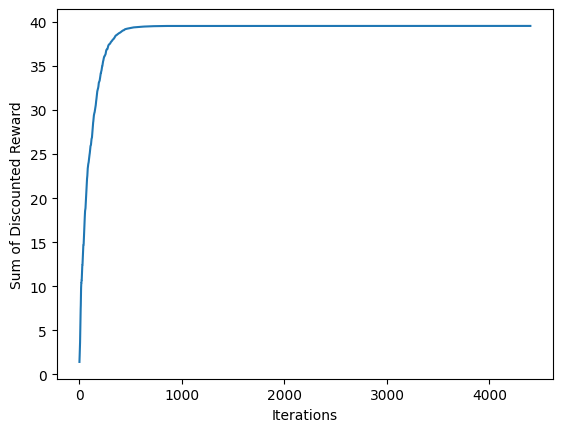

In [ ]:
# Discounted reward vs iterations
plt.xlabel('Iterations')
plt.ylabel('Sum of Discounted Reward')
plt.plot(disc_reward_list)

In [ ]:
print(plot_d_coeff)
# print(plot_d_coeff_gr)
print(plot_d_coeff_qlearning)

In [ ]:
def average(s):
  d_q_n = [s[x:x+250] for x in range(0, len(s),250 )]
  means_1 = [sum(group)/len(group) for group in d_q_n]
  return means_1


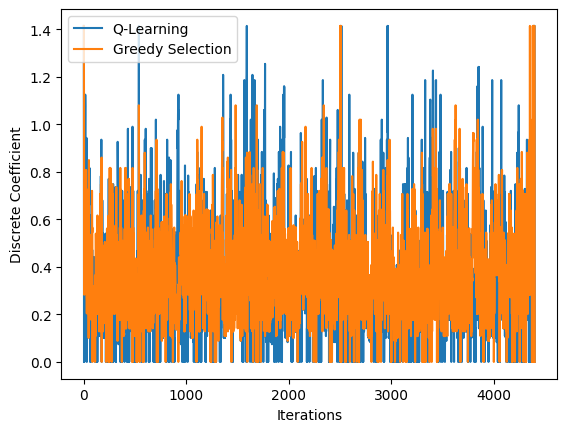

In [ ]:
import matplotlib.pyplot as plt
# Discrete coefficient vs iterations
plt.xlabel('Iterations')
plt.ylabel('Discrete Coefficient')
plt.plot(range(0,len(discrete_coeff_list_qlearning)),discrete_coeff_list_qlearning, label='Q-Learning')
plt.plot(range(0,len(discrete_coeff_list_gr)),discrete_coeff_list_gr, label='Greedy Selection')
#plt.plot(time, plot_d_coeff_qlearning, label='Q')
plt.legend()



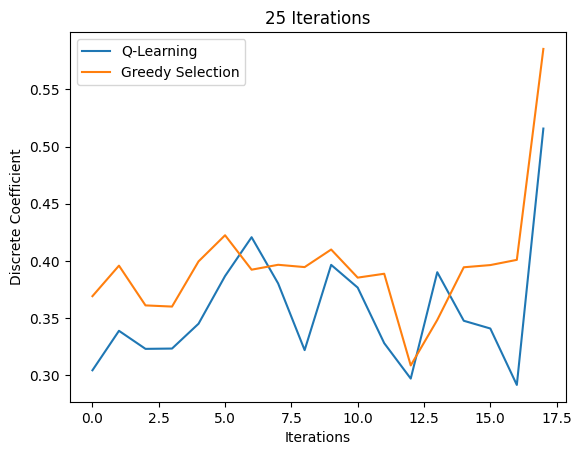

In [ ]:
av_ql=average(discrete_coeff_list_qlearning)
av_gr=average(discrete_coeff_list_gr)
plt.xlabel('Iterations')
plt.ylabel('Discrete Coefficient')
plt.plot(range(0,len(av_ql)),av_ql, label='Q-Learning')
plt.plot(range(0,len(av_gr)),av_gr, label='Greedy Selection')
plt.title("25 Iterations")
#plt.plot(time, plot_d_coeff_qlearning, label='Q')
plt.legend()

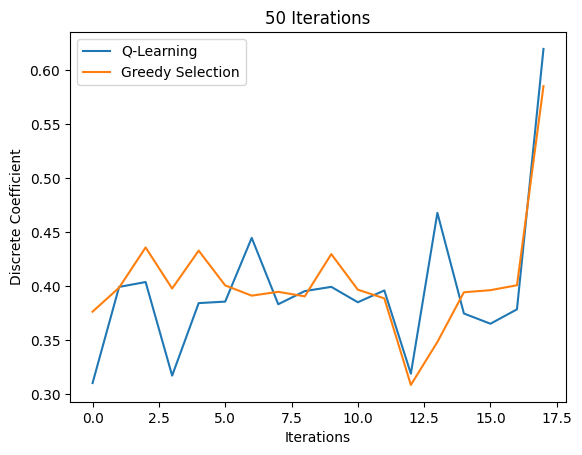

In [ ]:
av_ql=average(discrete_coeff_list_qlearning)
av_gr=average(discrete_coeff_list_gr)
plt.xlabel('Iterations')
plt.ylabel('Discrete Coefficient')
plt.plot(range(0,len(av_ql)),av_ql, label='Q-Learning')
plt.plot(range(0,len(av_gr)),av_gr, label='Greedy Selection')
plt.title("50 Iterations")
#plt.plot(time, plot_d_coeff_qlearning, label='Q')
plt.legend()

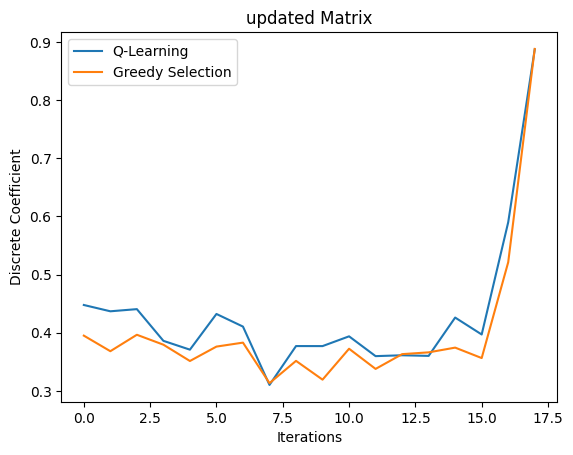

In [ ]:
av_ql=average(discrete_coeff_list_qlearning)
av_gr=average(discrete_coeff_list_gr)
plt.xlabel('Iterations')
plt.ylabel('Discrete Coefficient')
plt.plot(range(0,len(av_ql)),av_ql, label='Q-Learning')
plt.plot(range(0,len(av_gr)),av_gr, label='Greedy Selection')
plt.title("updated Matrix")
#plt.plot(time, plot_d_coeff_qlearning, label='Q')
plt.legend()

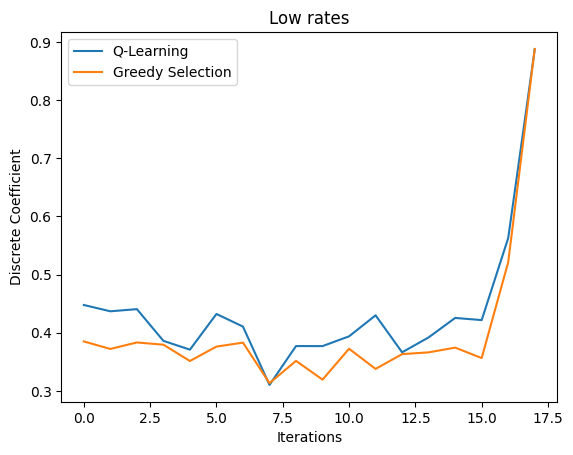

In [ ]:
av_ql=average(discrete_coeff_list_qlearning)
av_gr=average(discrete_coeff_list_gr)
plt.xlabel('Iterations')
plt.ylabel('Discrete Coefficient')
plt.plot(range(0,len(av_ql)),av_ql, label='Q-Learning')
plt.plot(range(0,len(av_gr)),av_gr, label='Greedy Selection')
plt.title("Low rates")
#plt.plot(time, plot_d_coeff_qlearning, label='Q')
plt.legend()

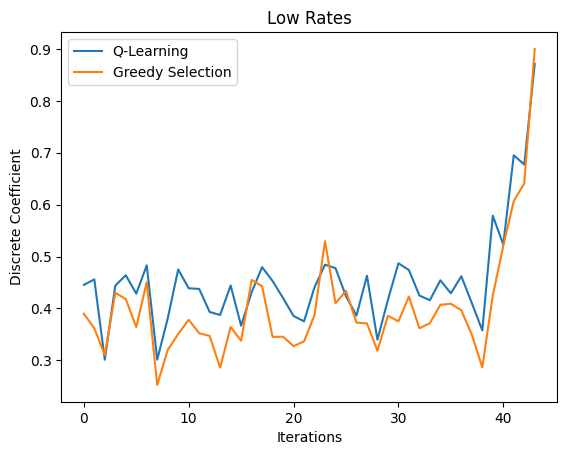

In [ ]:
av_ql=average(discrete_coeff_list_qlearning)
av_gr=average(discrete_coeff_list_gr)
plt.xlabel('Iterations')
plt.ylabel('Discrete Coefficient')
plt.plot(range(0,len(av_ql)),av_ql, label='Q-Learning')
plt.plot(range(0,len(av_gr)),av_gr, label='Greedy Selection')
plt.title("Low Rates")
#plt.plot(time, plot_d_coeff_qlearning, label='Q')
plt.legend()

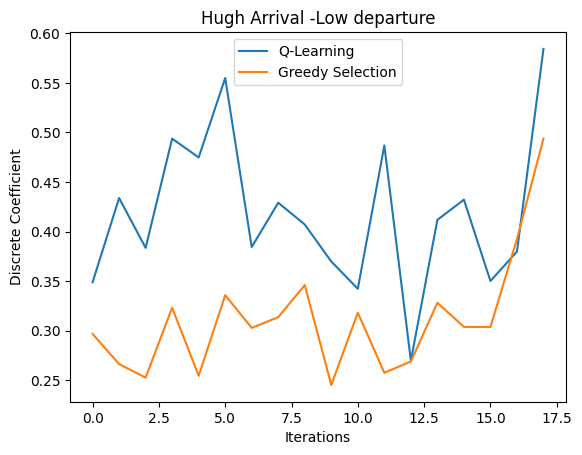

In [ ]:
av_ql=average(discrete_coeff_list_qlearning)
av_gr=average(discrete_coeff_list_gr)
plt.xlabel('Iterations')
plt.ylabel('Discrete Coefficient')
plt.plot(range(0,len(av_ql)),av_ql, label='Q-Learning')
plt.plot(range(0,len(av_gr)),av_gr, label='Greedy Selection')
plt.title("Hugh Arrival -Low departure")
#plt.plot(time, plot_d_coeff_qlearning, label='Q')
plt.legend()

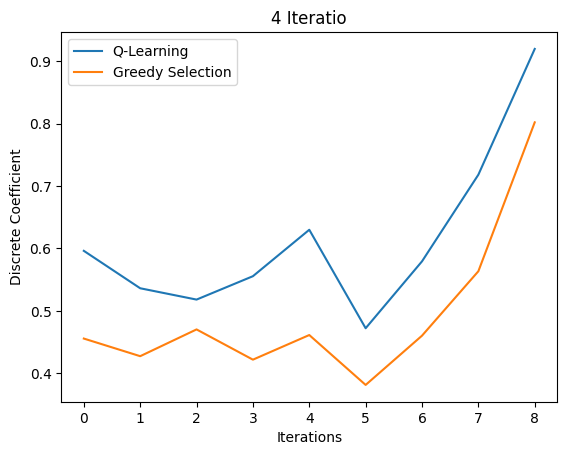

In [ ]:
av_ql=average(discrete_coeff_list_qlearning)
av_gr=average(discrete_coeff_list_gr)
plt.xlabel('Iterations')
plt.ylabel('Discrete Coefficient')
plt.plot(range(0,len(av_ql)),av_ql, label='Q-Learning')
plt.plot(range(0,len(av_gr)),av_gr, label='Greedy Selection')
plt.title("4 Iteratio")
#plt.plot(time, plot_d_coeff_qlearning, label='Q')
plt.legend()

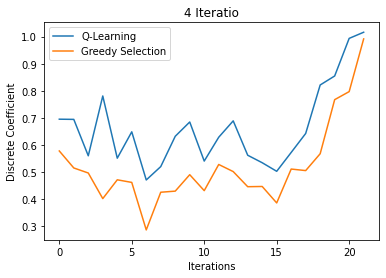

In [ ]:
av_ql=average(discrete_coeff_list_qlearning)
av_gr=average(discrete_coeff_list_gr)
plt.xlabel('Iterations')
plt.ylabel('Discrete Coefficient')
plt.plot(range(0,len(av_ql)),av_ql, label='Q-Learning')
plt.plot(range(0,len(av_gr)),av_gr, label='Greedy Selection')
plt.title("4 Iteratio")
#plt.plot(time, plot_d_coeff_qlearning, label='Q')
plt.legend()

In [ ]:
# Discrete coefficient vs iterations
# plt.xlabel('Iterations')
# plt.ylabel('Discrete Coefficient')
# plt.plot(time, plot_d_coeff_random, label='Random Selection')
# plt.legend()

In [ ]:
# Discrete coefficient vs iterations
plt.xlabel('Iterations')
plt.ylabel('Number of switch exchange')
# plt.plot(time, number_of_switches_list_gr, label='Greedy Selection')
plt.plot(time, plot_switch_migration_q, label='qlearning')
plt.legend()

In [ ]:
# import csv
# with open('Migration_newq.csv', 'w') as f:
#     writer = csv.writer(f, delimiter='\t')
#     writer.writerows(zip(plot_switch_migration_q,plot_switch_migration_g))

In [ ]:
# with open('Discrete_newq.csv', 'w') as f:
#     writer = csv.writer(f, delimiter='\t')
#     writer.writerows(zip(plot_d_coeff,plot_d_coeff_gr))

In [ ]:


file = open("Qmatrix.txt", "w")

#convert variable to string
str = repr(Q_matrix)
file.write("input_dictionary = " + str + "\n")

#close file
file.close()


In [ ]:
import pandas as pd

# print(len(states_list_random))
# print(len(controllers_list_random))

# print(len(states_list_q))
# print(len(controllers_list_q))
# print(len(discrete_coeff_list_qlearning))
# print(len(reward_list))
# print(len(load_array_each_iteration))
# dict_random = {'state': states_list_random, 'ca': controllers_list_random
dict_q = {'state': states_list_q, 'ca': controllers_list_q, 'Selection based on': choice_based,'disc_coeff':discrete_coeff_list_qlearning, 'reward_list':reward_list, 'load_array_each_iteration' : load_array_each_iteration,'Greedy_discrete_coeff':discrete_coeff_list_gr}
# df_r = pd.DataFrame(dict_random)
df_q = pd.DataFrame(dict_q)


# df_r.to_csv('random.csv')
df_q.to_csv('q_modifed.csv')
